In [1]:
import os,sys,string, time
import ROOT
from math import *
from ROOT import gPad, TTree, TObject, TFile, gDirectory, TH1D, TH2D, TH3D, TCanvas, gROOT, TGaxis, gStyle, TColor, TLegend, THStack, TChain, TLatex, TText, TCollection, kRed, kBlue
from array import array
import matplotlib.pyplot as plt
import numpy as np
import uproot
import pandas as pd
from root_pandas import read_root
from platform import python_version
import scipy
from scipy import stats
import uproot3
import math
from matplotlib.patches import Rectangle
import pickle

import Utilities.Plotter as PT
import Utilities.Constants as Constants
import Utilities.Variables_list as Variables

print ('Success')



Welcome to JupyROOT 6.24/06
Success


## Functions

In [2]:
#Defining functions
def Preselection_with_list(df_cut, cut_dict, Efficiency_list): #This only works for a conditional with one variable, NOT TRUE, key name doesn't matter?
    NumEvs = len(df_cut)
    for cut in cut_dict.keys():
        df_cut=df_cut.query(cut_dict[cut])
        Efficiency_list.append(len(df_cut)/NumEvs)
        
def Edit_Weight_Tune(df_to_Tune): #This is taken from Aditya's code, Owen also has the same in his for overlay and dirt, there is the same block in PELEE code
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] <= 0, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] == np.inf, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ df_to_Tune['weightSplineTimesTune'] > 50, 'weightSplineTimesTune' ] = 1.
    df_to_Tune.loc[ np.isnan(df_to_Tune['weightSplineTimesTune']) == True, 'weightSplineTimesTune' ] = 1.
    return df_to_Tune

def MC_weight_branch(df_MC): #Writes a new branch called "weight" including, ppfx, weightSplineTimesTune AND if pi0 are present, scales by pi0 factor
    df_MC["weight"] = df_MC["ppfx_cv"]*df_MC["weightSplineTimesTune"] 
    df_MC.loc[df_MC["npi0"]>0,"weight"] = df_MC["weight"][df_MC["npi0"]>0]*Constants.pi0_scaling_factor #If MC event contains pi0, need to scale down, derived from BNB data
    
def Plot_one_variable(signal, background, variable_name, numbins, range_lims=None, loghist=False):
    plt.figure(figsize=(12,8),facecolor='white')
    plot1 = plt.figure(1)
    plt.hist(signal[variable_name],bins=numbins,label="Signal",alpha=0.5, range=range_lims)
    plt.hist(background[variable_name],bins=numbins,label="Background",alpha=0.5, range=range_lims)
    if loghist == True:
        plt.yscale("log")
    else:
        plt.yscale("linear")
    plt.xlabel(variable_name)
    plt.ylabel('Number of events')
    plt.legend()
    
def Make_pkl(df_pkl, name):
    df_pkl.to_pickle(name)
    
def check_is_truth(df_MC, df_EXT, var):
    vals_MC = []
    vals_EXT = []
    for i in range(100):
        vals_MC.append(df_MC[var][i])
        vals_EXT.append(df_EXT[var][i])
    unique_MC = set(vals_MC)
    unique_EXT = set(vals_EXT)
    print("For the variable \"" + str(var) + "\"" + "\n")

    print("There are " + str(len(unique_MC)) + " unique values in MC.")
    print("There are " + str(len(unique_EXT))+ " unique values in EXT." + "\n")

    print_vals = input("Do you want to see the values of vars? y/n ")
    if print_vals == "y":
        print("MC values are : " + str(unique_MC))
        print("EXT values are: " + str(unique_EXT))
    return 0

In [3]:
First_pass_vars = Variables.First_pass_vars
First_pass_vars_MC = Variables.First_pass_vars_MC

variables_run1 = Variables.Preselection_vars
variables_run3 = Variables.Preselection_vars_CRT
variables_run1_MC = Variables.Preselection_vars_MC
variables_run3_MC = Variables.Preselection_vars_CRT_MC

print("Number of variables for data:")
print(len(First_pass_vars))
print("Number of variables for MC:")
print(len(First_pass_vars_MC))

Number of variables for data:
118
Number of variables for MC:
121


# Reading in and pickling files

In [7]:
HNL_masses = Constants.HNL_mass_samples #in MeV

Run = "run3" #so far either "run1" or "run3"

filetype = "signal" #can be overlay, dirt, EXT or signal

only_presel = True

FLATTEN = False

chunksize = 10000 #For saving pkls in chunks, not yet implemented

if Run == "run1":
    current = "FHC"
    if only_presel == True:
        variables = variables_run1
        variables_MC = variables_run1_MC
    else:
        variables = First_pass_vars
        variables_MC = First_pass_vars_MC
elif Run == "run3":
    current = "RHC"
    if only_presel == True:
        variables = variables_run3
        variables_MC = variables_run3_MC
    else:
        variables = First_pass_vars
        variables_MC = First_pass_vars_MC
else:
    print("Need to choose either \"run1\" or \"run3\"")
    
if FLATTEN == True:
    Flat_state = "flattened"
else:
    Flat_state = "unflattened"
    
if only_presel:
    variables_string = "Presel_vars"
else:
    variables_string = "my_vars"

root_dir = 'nuselection'
main_tree = 'NeutrinoSelectionFilter'
MC_samples_dir = '../NuMI_MC/'
data_samples_dir = '../NuMI_data/'
signal_samples_dir = '../NuMI_signal/KDAR_dump/sfnues/'

loc_overlay_run1 = MC_samples_dir+'SLIMMED_neutrinoselection_filt_run1_overlay.root'#NuMI Run1 MC WITHOUT systematics weights
loc_dirt_run1 = MC_samples_dir+'prodgenie_numi_uboone_overlay_dirt_fhc_mcc9_run1_v28_all_snapshot.root'
loc_EXT_run1 = data_samples_dir+'neutrinoselection_filt_run1_beamoff.root'

loc_overlay_run3 = MC_samples_dir+'SLIMMED_neutrinoselection_filt_run3b_overlay.root' #NuMI Run3 MC WITHOUT systematics weights
loc_dirt_run3 = MC_samples_dir+'neutrinoselection_filt_run3b_dirt_overlay.root'
loc_EXT_run3 = data_samples_dir+'neutrinoselection_filt_run3b_beamoff.root'

loc_pkls = f"pkl_files/{Run}/current_files/{variables_string}/"

if filetype == "overlay":
    print("Loading overlay with uproot")
    if Run == "run1":
        NuMI_MC_overlay = uproot3.open(loc_overlay_run1)[root_dir+'/'+main_tree]
    elif Run == "run3":
        NuMI_MC_overlay = uproot3.open(loc_overlay_run3)[root_dir+'/'+main_tree]
    df_overlay = NuMI_MC_overlay.pandas.df(variables_MC, flatten=FLATTEN)
    file = df_overlay
    Edit_Weight_Tune(file)
    MC_weight_branch(file)
    new_overlay = file.copy()
    del(file)
    print(f"Pickling {Run} overlay file")
    new_overlay.to_pickle(loc_pkls+f"overlay_{Run}_{variables_string}_"+Flat_state+".pkl")
    del(new_overlay)
elif filetype == "dirt":
    print("Loading dirt with uproot")
    if Run == "run1":
        NuMI_MC_dirt = uproot3.open(loc_dirt_run1)[root_dir+'/'+main_tree]
    elif Run == "run3":
        NuMI_MC_dirt = uproot3.open(loc_dirt_run3)[root_dir+'/'+main_tree]
    df_dirt = NuMI_MC_dirt.pandas.df(variables_MC, flatten=FLATTEN)
    file = df_dirt
    Edit_Weight_Tune(file)
    MC_weight_branch(file)
    new_dirt = file.copy()
    del(file)
    print(f"Pickling {Run} dirt file")
    new_dirt.to_pickle(loc_pkls+f"dirt_{Run}_{variables_string}_"+Flat_state+".pkl")
    del(new_dirt)
elif filetype == "EXT":
    print("Loading EXT with uproot")
    if Run == "run1":
        NuMI_EXT = uproot3.open(loc_EXT_run1)[root_dir+'/'+main_tree]
    elif Run == "run3":
        NuMI_EXT = uproot3.open(loc_EXT_run3)[root_dir+'/'+main_tree]
    df_EXT = NuMI_EXT.pandas.df(variables, flatten=FLATTEN)
    file = df_EXT
    new_EXT = file.copy()
    del(file)
    print(f"Pickling {Run} EXT file")
    new_EXT.to_pickle(loc_pkls+f"EXT_{Run}_{variables_string}_"+Flat_state+".pkl")
    del(new_EXT)
elif filetype == "signal":
    print("Loading signal files with uproot")
    for HNL_mass in HNL_masses:
        loc_signal_run1 = signal_samples_dir+f'sfnues_KDAR_dump_{HNL_mass}_Umu4_majorana_numi_{current}.root'
        Signal_run1 = uproot3.open(loc_signal_run1)[root_dir+'/'+main_tree]
        df_signal_run1 = Signal_run1.pandas.df(variables, flatten=FLATTEN)
        file = df_signal_run1
        new_signal = file.copy()
        del(file)
        print(f"Pickling {Run} {HNL_mass}MeV file")
        new_signal.to_pickle(loc_pkls+f"signal_{HNL_mass}MeV_{Run}_{variables_string}_"+Flat_state+".pkl")
        del(new_signal)
else:
    print("Not a valid filetype")

print("Success")

Loading signal files with uproot
Pickling run3 20MeV file
Pickling run3 50MeV file
Pickling run3 100MeV file
Pickling run3 150MeV file
Pickling run3 180MeV file
Pickling run3 200MeV file
Success


In [17]:
overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_my_vars_flattened.pkl")

Preselection_efficiency_signal = [1.0]

Preselection_with_list(overlay_from_pkl, Constants.Preselection_dict, Preselection_efficiency_signal)

In [9]:
print(len(overlay_from_pkl))

987945


# Plotting Variables before preselection

In [13]:
My_vars = Variables.First_pass_vars
My_vars_MC = Variables.First_pass_vars_MC

overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_my_vars1_flattened.pkl")
dirt_from_pkl = pd.read_pickle(loc_pkls+"dirt_run1_my_vars1_flattened.pkl")
EXT_from_pkl = pd.read_pickle(loc_pkls+"EXT_run1_my_vars1_flattened.pkl")
signal_from_pkl = pd.read_pickle(loc_pkls+f"signal_100MeV_run1_my_vars1_flattened.pkl")

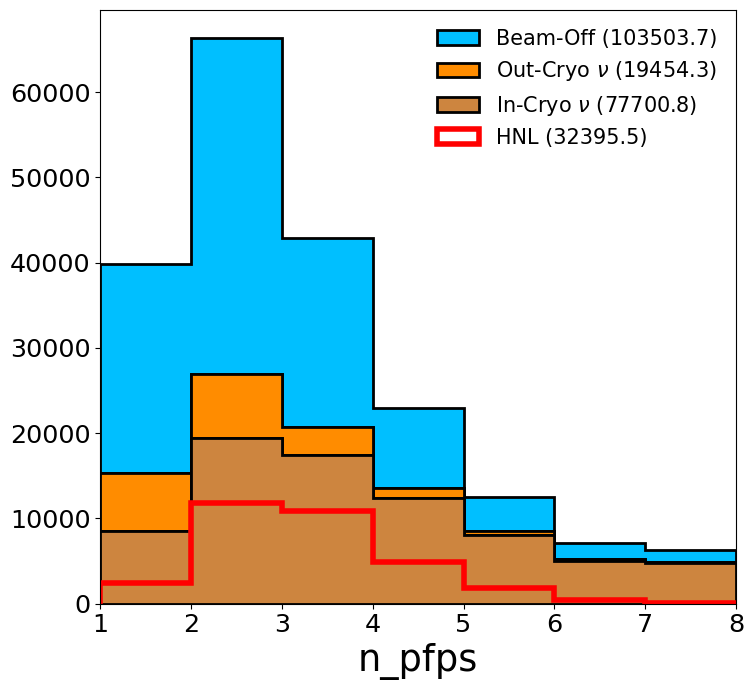

In [19]:
samples = {"overlay":overlay_from_pkl,
           "dirtoverlay":dirt_from_pkl,
           "beamoff":EXT_from_pkl,
           "signal":signal_from_pkl}
sample_norms = {"overlay":SF_overlay_run1,
           "dirtoverlay":SF_dirt_run1,
           "beamoff":SF_EXT_run1,
           "signal":SF_signal_run1}

PT.Plot_preselection_variable("n_pfps", samples, sample_norms, xlabel=[],xlims=[1,8],bins=7,figsize=[8,8],HNLplotscale=10000000,logy="False")

## Load in all branches for small number of events

In [ ]:
NuMI_MC_dirt_run1 = uproot3.open(loc_dirt_run1)[root_dir+'/'+main_tree]
NuMI_EXT_run1 = uproot3.open(loc_EXT_run1)[root_dir+'/'+main_tree]
#NuMI_beamgood_run1 = uproot3.open(loc_beamgood_run1)[root_dir+'/'+main_tree]
Signal_run1 = uproot3.open(loc_signal_run1)[root_dir+'/'+main_tree]

print("----MC OVERLAY BACKGROUND----")
print("Number of branches is " + str(len(NuMI_MC_overlay_run1.keys()))) 
print("Number of events is " + str(NuMI_MC_overlay_run1.numentries))
print("----MC DIRT BACKGROUND----")
print("Number of branches is " + str(len(NuMI_MC_dirt_run1.keys()))) 
print("Number of events is " + str(NuMI_MC_dirt_run1.numentries))
print("----EXT BACKGROUND----")
print("Number of branches is " + str(len(NuMI_EXT_run1.keys()))) 
print("Number of events is " + str(NuMI_EXT_run1.numentries))
# print("----DATA----")
# print("Number of branches is " + str(len(NuMI_beamgood_run1.keys()))) 
# print("Number of events is " + str(NuMI_beamgood_run1.numentries))
print("----SIGNAL----")
print("Number of branches is " + str(len(Signal_run1.keys()))) 
print("Number of events is " + str(Signal_run1.numentries))

NumEvents = 10
FLATTEN = False

df_overlay_run1 = NuMI_MC_overlay_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_dirt_run1 = NuMI_MC_dirt_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_EXT_run1 = NuMI_EXT_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)
df_signal_run1 = Signal_run1.pandas.df("*", entrystop=NumEvents, flatten=FLATTEN)

overlay_vars = df_overlay_run1.keys()
dirt_vars = df_dirt_run1.keys()
EXT_vars = df_EXT_run1.keys()
signal_vars = df_signal_run1.keys()

In [ ]:
# for i in overlay_vars:
#     print(i)
    
overlay_no_truth_vars = []
    
for j in overlay_vars:
    if 'true' in j:
        continue
    if 'truth' in j:
        continue
    if 'mc_' in j:
        continue
    overlay_no_truth_vars.append(j)
    #print(j)

print(len(overlay_no_truth_vars))

# Testing other ways of saving .pkls

In [ ]:
# run1_samples = [overlay_from_pkl, dirt_from_pkl, EXT_from_pkl, signal_from_pkl]
# run1_sample_names = ["df_overlay_run1", "df_dirt_run1", "df_EXT_run1", "df_signal_run1"] #Better way to do this, dictionary?

# loc_pkls = "pkl_files/"
# i = 0

# for sample in run1_samples:
#     sample.to_pickle(loc_pkls+run1_sample_names[i]+"_full.pkl")
#     i+=1

In [ ]:
# flattened_overlay_from_pkl = pd.read_pickle(loc_pkls+"overlay_run1_Aditya_vars_flattened.pkl")

# NumEvs_overlay_run1 = 914728 #Should have this saved somewhere, or perhaps accessed direcly from uproot? 

# print(flattened_overlay_from_pkl['nslice'])
# print(flattened_overlay_from_pkl['nslice'][0])

# number_evs_removed = 0
# number_evs_kept = 0
# for entry in range(NumEvs_overlay_run1):
#     #if entry in flattened_overlay_from_pkl['nslice']:
#     if entry in flattened_overlay_from_pkl.index:
#         number_evs_kept += 1
#     else:
#         number_evs_removed += 1

# print("Number of events kept is " + str(number_evs_kept))
# print("Number of events removed is " + str(number_evs_removed))



In [ ]:
#Fraction with nslice of 1 is 0.41223401929316694
fraction_reco = number_evs_kept/(number_evs_kept+number_evs_removed)
print("Fraction with nslice of 1 is " + str(fraction_reco))